In [50]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import torchvision.transforms as transforms
import torchvision.models as models


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [53]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.axis("off")
        plt.title(title)
        plt.imshow(img)
    plt.show()


Train lowlight 이미지 개수: 3686


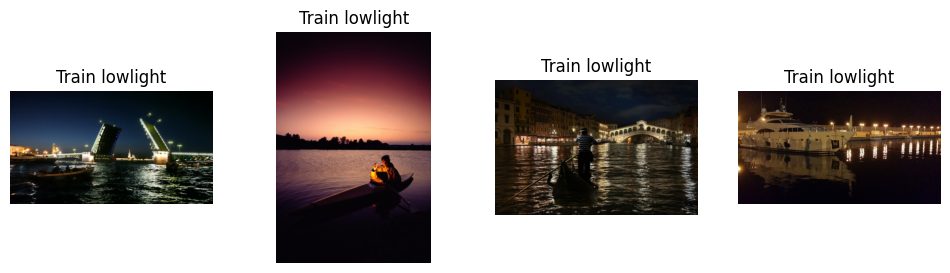

Train normal 이미지 개수: 3846


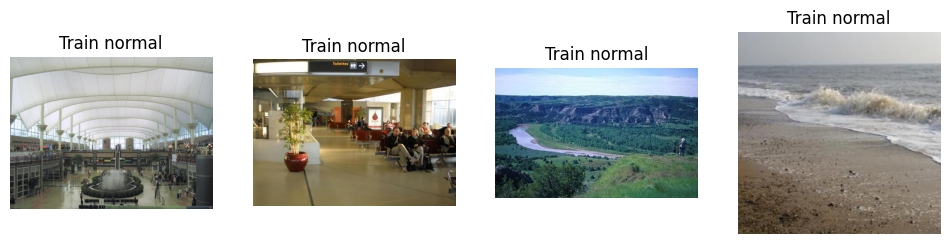

Val lowlight 이미지 개수: 652


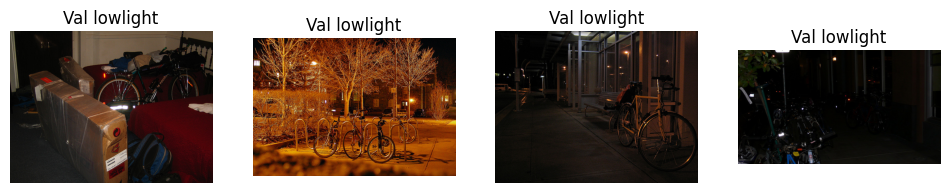

Val normal 이미지 개수: 689


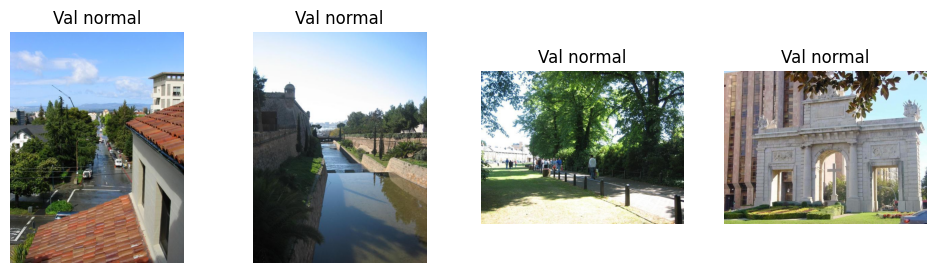

Test lowlight 이미지 개수: 50


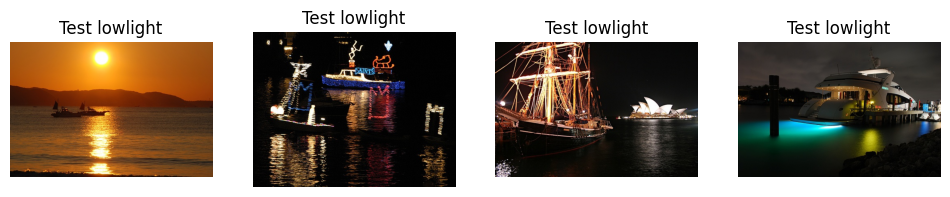

Test normal 이미지 개수: 50


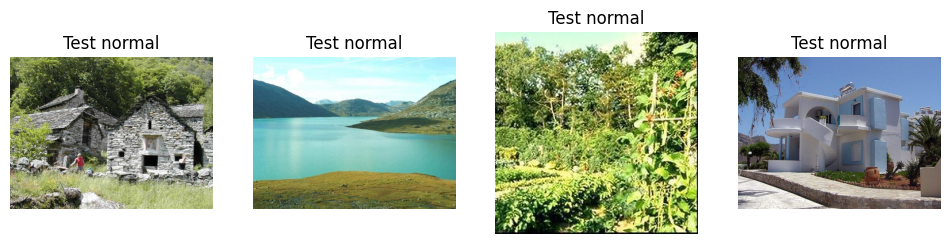

In [54]:
categories = ["Train lowlight", "Train normal", "Val lowlight", "Val normal", "Test lowlight", "Test normal"]

for category in categories:
    image_paths = glob.glob(f"../실습 파일/5/{category.lower().replace(' ', '/')}/*")
    print(f"{category} 이미지 개수: {len(image_paths)}")
    display_images(image_paths, category)


















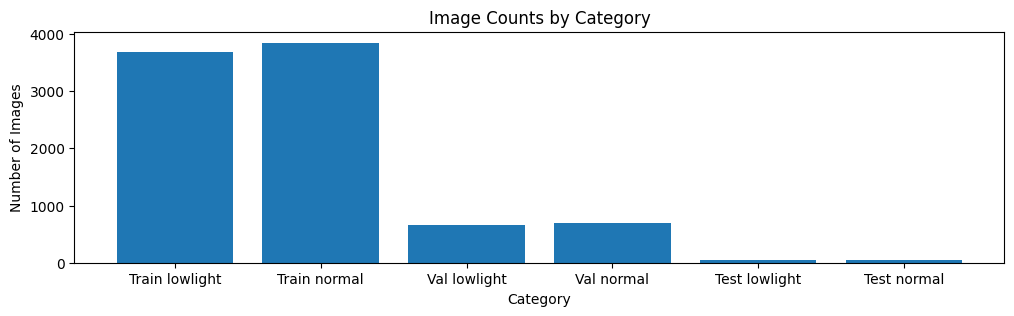

In [55]:
plt.figure(figsize=(12, 3))
plt.bar(categories, [len(glob.glob(f"../실습 파일/5/{category.lower().replace(' ', '/')}/*")) for category in categories])
plt.title("Image Counts by Category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()





In [56]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-10, 10)),
        ])
        
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)
    
# imgaug를 사용한 커스텀 데이터셋 정의(light 변화 추가)
class ImgAugTransform_Light:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20)),
            iaa.Multiply((0.5, 1.5)),
            iaa.LinearContrast((0.5, 1.5)),
            iaa.HistogramEqualization(),
            iaa.CLAHE(),
            iaa.GammaContrast((0.5, 2.0)),
        ])
        
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)
    
        
        


In [57]:
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug = None, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        
        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL 이미지로 변환
            img = Image.fromarray(img)
            
        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target
        
            


In [58]:
# PyTorch transforms에서 ToTensor 및 Normalize 적용
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




In [59]:
train_dataset = CustomDataset(root="../실습 파일/5/train", imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset(root="../실습 파일/5/val", imgaug=None, transform=pytorch_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)



In [60]:
from torch.utils.data import SubsetRandomSampler

# 데이터셋 인덱스 생성
num_of_train = len(train_dataset)
num_of_val = len(val_dataset)
train_indices = list(range(num_of_train))
val_indices = list(range(num_of_val))

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

# 데이터셋 인덱스 랜덤 추출
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)



In [61]:
# DataLoader에서 샘플 이미지를 load하고 show함수
def imshow(img, size=(20, 20), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


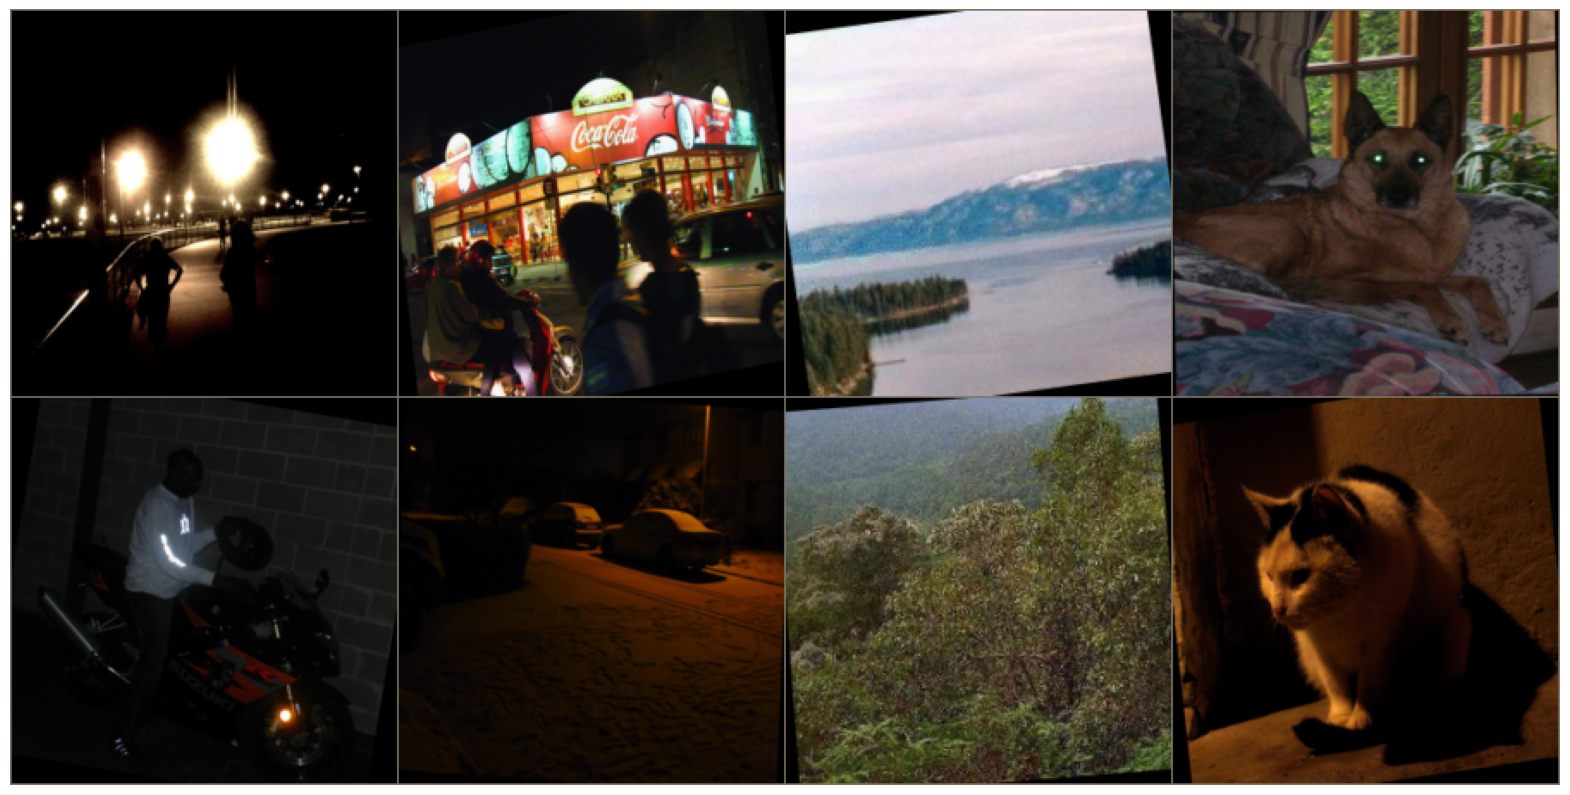

In [62]:
dataiter = iter(train_loader)
images, _ = next(dataiter)

imshow(make_grid(images[:8], nrow=4, padding=1), size=(20, 20))








In [63]:
# Resnet 모델 불러오기
net = models.resnet50(pretrained=True)
net


c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [64]:
for param in net.parameters():
    param.requires_grad = False


In [65]:
# classifier의 마지막 레이어를 Binary Classification으로 변경, 파라미터 학습 가능하게끔
net.fc = nn.Linear(net.fc.in_features, 2)
net.fc.requires_grad = True


In [66]:
net = net.to(device)


In [67]:
criterion = nn.CrossEntropyLoss()


In [68]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=30):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Invalid optimizer: {optimizer_name}")
    
    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()        # 역전파
            optimizer.step()       # 가중치 업데이트
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 검증 단계
        net.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies

In [69]:
train_losses_default_aug, val_losses_default_aug, val_accuracies_default_aug = train_model('AdamW', net, train_loader, val_loader, criterion)


Epoch 1/30, Train Loss: 0.3469, Val Loss: 0.2296, Val Accuracy: 96.27%
Epoch 2/30, Train Loss: 0.1575, Val Loss: 0.1577, Val Accuracy: 96.79%
Epoch 3/30, Train Loss: 0.1218, Val Loss: 0.1293, Val Accuracy: 96.94%
Epoch 4/30, Train Loss: 0.0938, Val Loss: 0.1105, Val Accuracy: 97.32%
Epoch 5/30, Train Loss: 0.0900, Val Loss: 0.1021, Val Accuracy: 97.39%
Epoch 6/30, Train Loss: 0.0802, Val Loss: 0.1024, Val Accuracy: 96.64%
Epoch 7/30, Train Loss: 0.0731, Val Loss: 0.0924, Val Accuracy: 97.76%
Epoch 8/30, Train Loss: 0.0699, Val Loss: 0.0833, Val Accuracy: 97.46%
Epoch 9/30, Train Loss: 0.0643, Val Loss: 0.0834, Val Accuracy: 97.69%
Epoch 10/30, Train Loss: 0.0640, Val Loss: 0.0796, Val Accuracy: 97.24%
Epoch 11/30, Train Loss: 0.0614, Val Loss: 0.0773, Val Accuracy: 97.32%
Epoch 12/30, Train Loss: 0.0634, Val Loss: 0.0879, Val Accuracy: 97.84%
Epoch 13/30, Train Loss: 0.0592, Val Loss: 0.0801, Val Accuracy: 97.02%
Epoch 14/30, Train Loss: 0.0552, Val Loss: 0.0799, Val Accuracy: 98.14%
E

In [70]:
# 초기화

train_dataset = CustomDataset(root="../실습 파일/5/train", imgaug=ImgAugTransform_Light(), transform=pytorch_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)


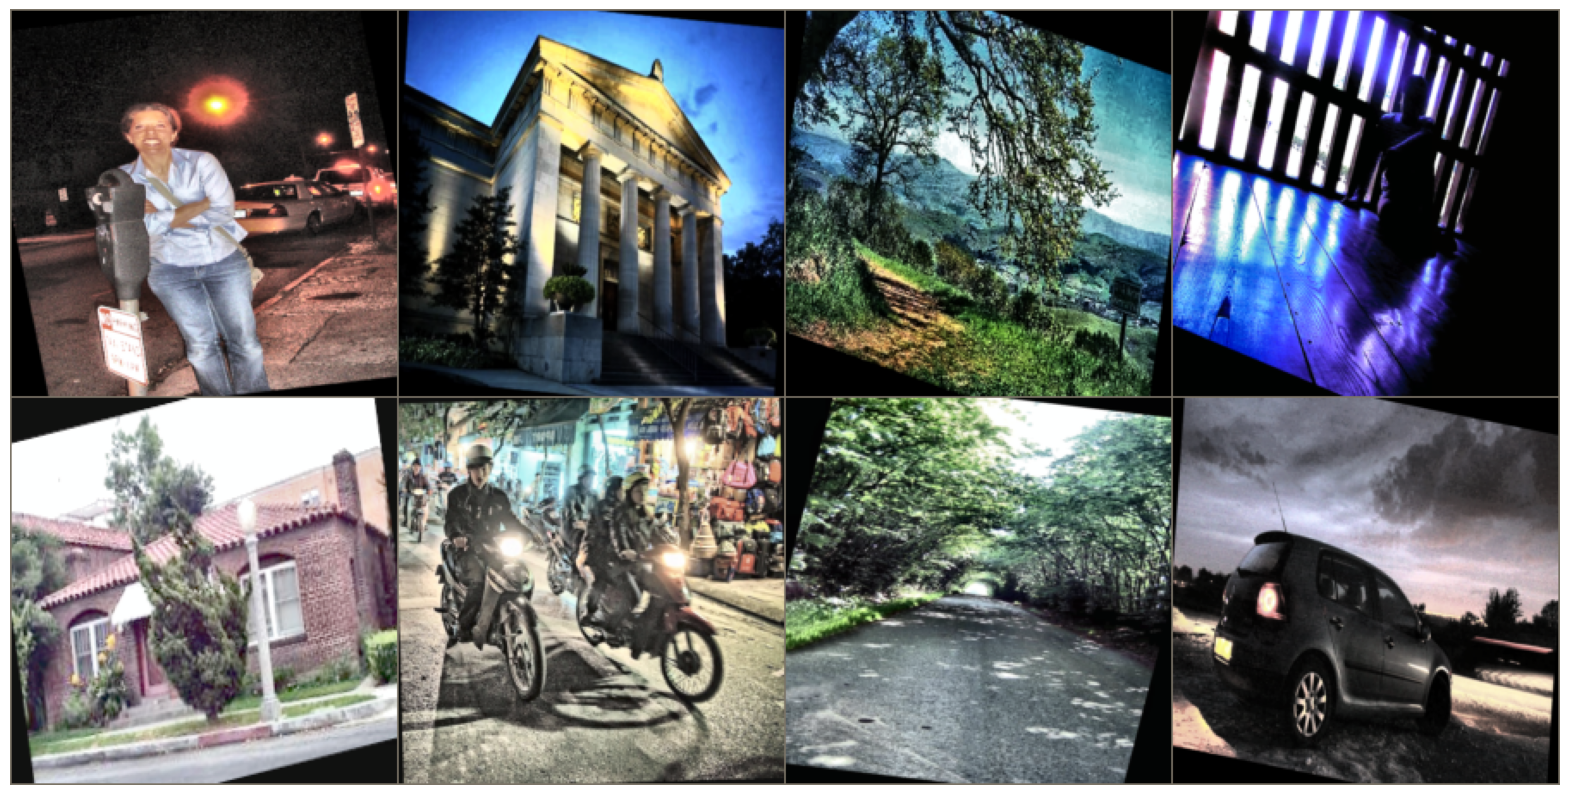

In [71]:
dataiter = iter(train_loader)
images, _ = next(dataiter)

imshow(make_grid(images[:8], nrow=4, padding=1), size=(20, 20))





In [72]:
net = models.resnet50(pretrained=True)
for param in net.parameters():
    param.requires_grad = False

net.fc = nn.Linear(net.fc.in_features, 2)
net.fc.requires_grad = True

net = net.to(device)


In [73]:
train_losses_light_aug, val_losses_light_aug, val_accuracies_light_aug = train_model('AdamW', net, train_loader, val_loader, criterion)


Epoch 1/30, Train Loss: 0.4088, Val Loss: 0.2933, Val Accuracy: 94.33%
Epoch 2/30, Train Loss: 0.2248, Val Loss: 0.2170, Val Accuracy: 94.71%
Epoch 3/30, Train Loss: 0.1784, Val Loss: 0.1849, Val Accuracy: 95.38%
Epoch 4/30, Train Loss: 0.1570, Val Loss: 0.1634, Val Accuracy: 95.75%
Epoch 5/30, Train Loss: 0.1463, Val Loss: 0.1552, Val Accuracy: 95.23%
Epoch 6/30, Train Loss: 0.1318, Val Loss: 0.1451, Val Accuracy: 95.53%
Epoch 7/30, Train Loss: 0.1215, Val Loss: 0.1425, Val Accuracy: 95.45%
Epoch 8/30, Train Loss: 0.1269, Val Loss: 0.1372, Val Accuracy: 95.67%
Epoch 9/30, Train Loss: 0.1156, Val Loss: 0.1349, Val Accuracy: 95.67%
Epoch 10/30, Train Loss: 0.1161, Val Loss: 0.1465, Val Accuracy: 94.63%
Epoch 11/30, Train Loss: 0.1072, Val Loss: 0.1451, Val Accuracy: 94.71%
Epoch 12/30, Train Loss: 0.1103, Val Loss: 0.1227, Val Accuracy: 96.20%
Epoch 13/30, Train Loss: 0.1052, Val Loss: 0.1438, Val Accuracy: 94.63%
Epoch 14/30, Train Loss: 0.1082, Val Loss: 0.1419, Val Accuracy: 94.41%
E

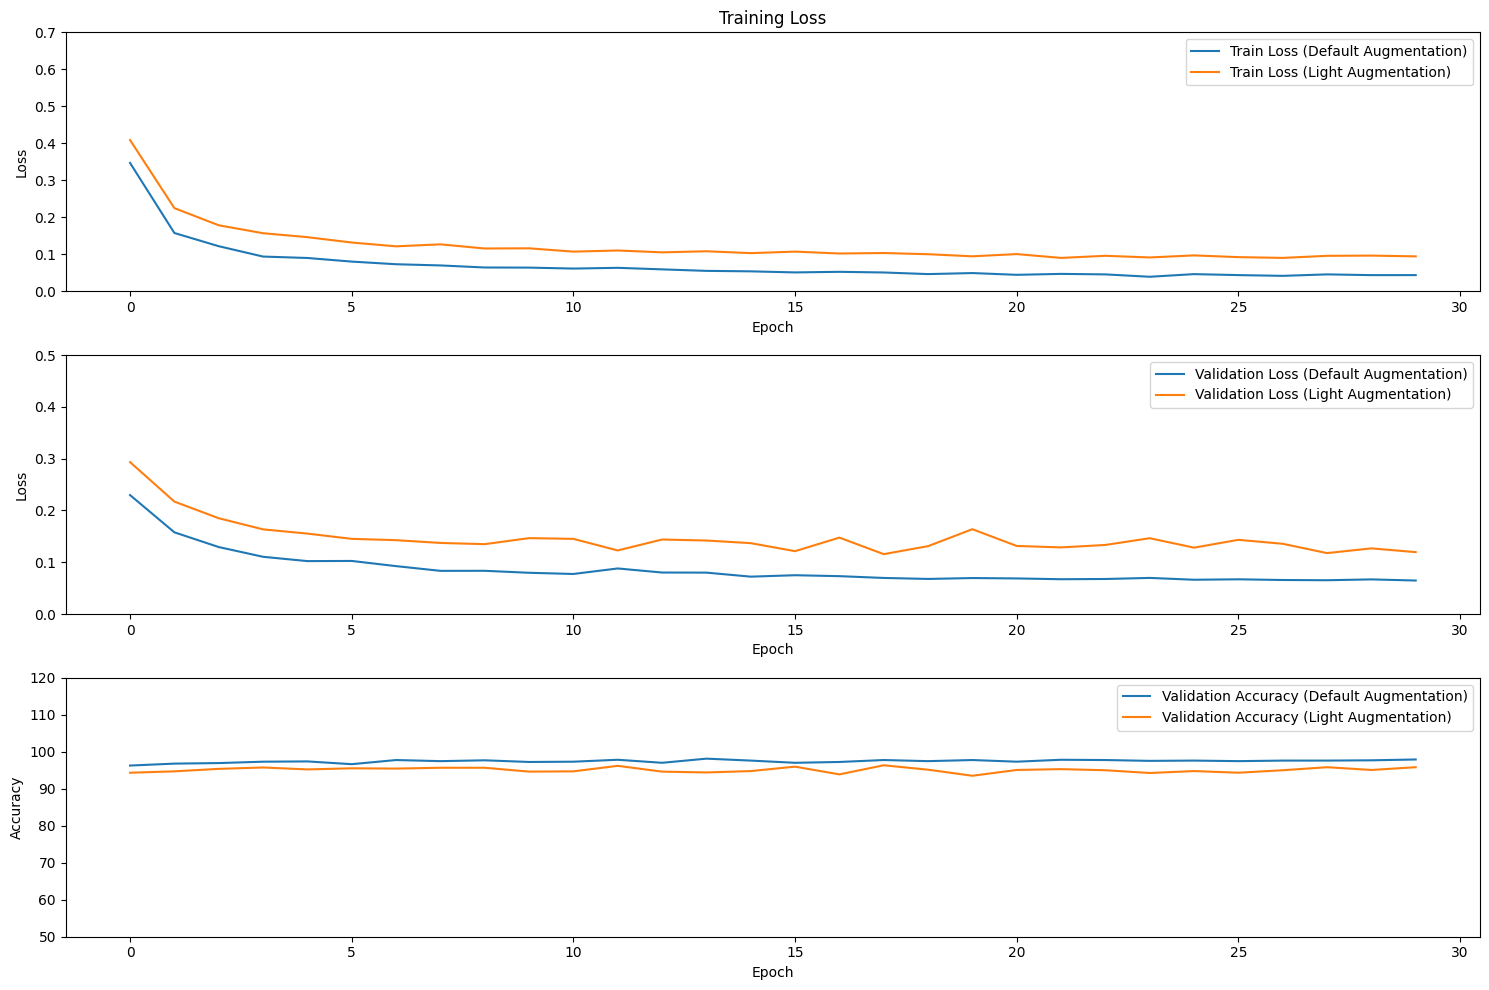

In [74]:
# 학습 손실과 검증 정확도 그래프 그리기

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_losses_default_aug, label='Train Loss (Default Augmentation)')
plt.plot(train_losses_light_aug, label='Train Loss (Light Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.ylim(0, 0.7)

# 검증 손실 그래프
plt.subplot(3, 1, 2)
plt.plot(val_losses_default_aug, label='Validation Loss (Default Augmentation)')
plt.plot(val_losses_light_aug, label='Validation Loss (Light Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 0.5)

# 검증 정확도 그래프
plt.subplot(3, 1, 3)
plt.plot(val_accuracies_default_aug, label='Validation Accuracy (Default Augmentation)')
plt.plot(val_accuracies_light_aug, label='Validation Accuracy (Light Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(50, 120)

plt.tight_layout()
plt.show()






In [75]:
# Image load 및 tensor로 변환

def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image.to(device)






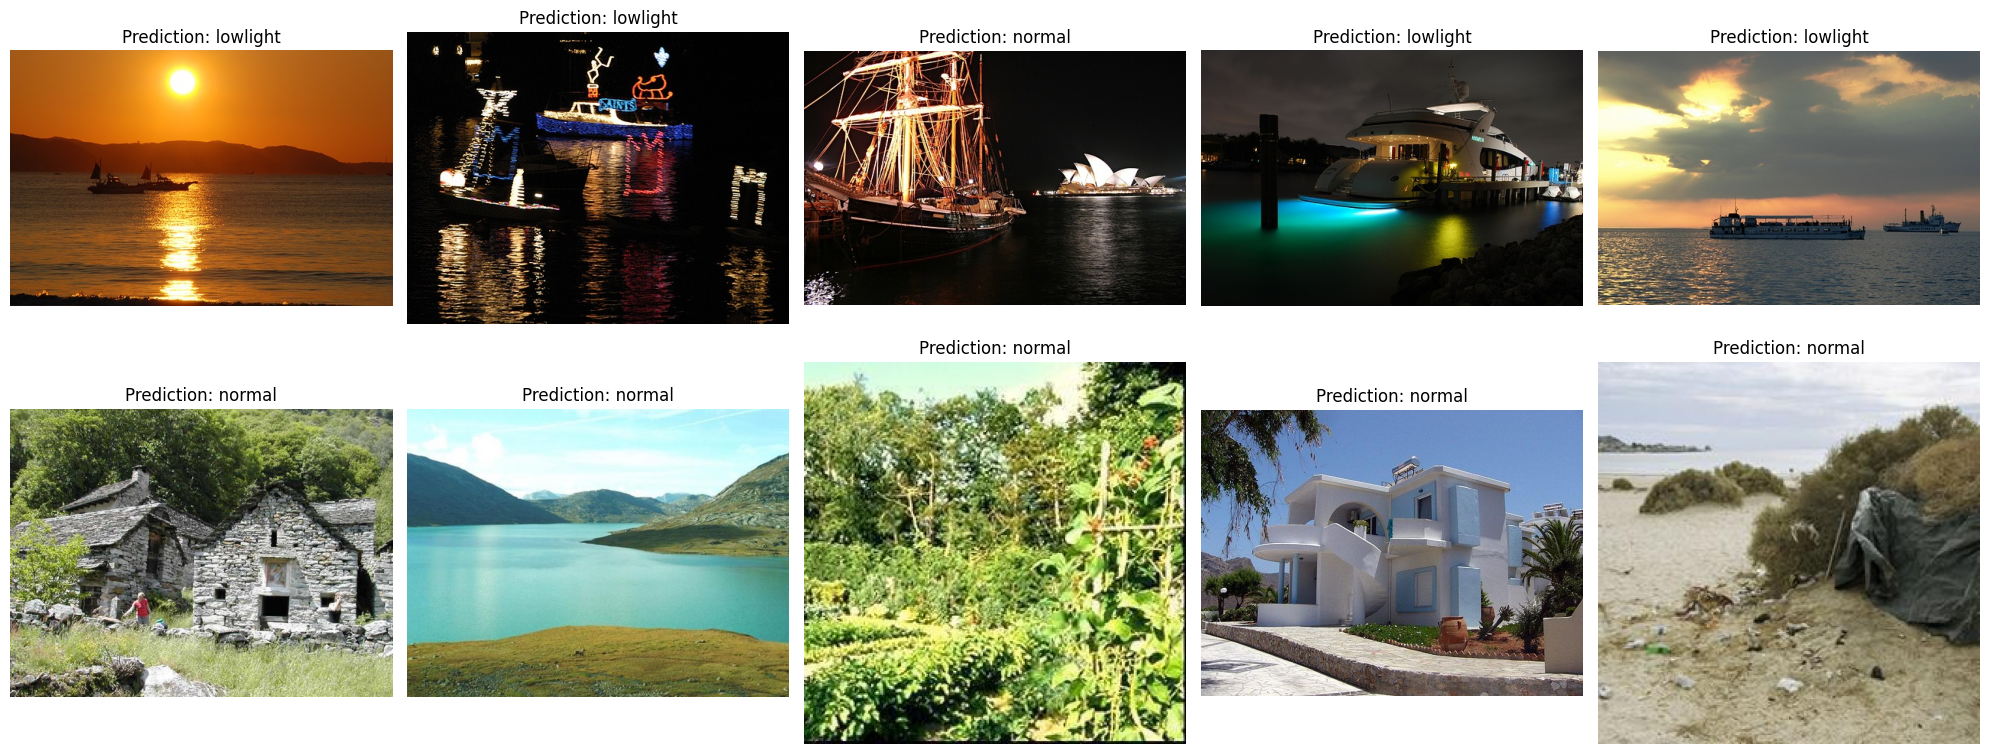

In [77]:
# 클래스별 폴더 경로
class_folders = {
    'lowlight': "../실습 파일/5/test/lowlight",
    'normal': "../실습 파일/5/test/normal"
}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, "*"))
    selected_paths = image_paths[:5]
    
    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)
        
        net.eval()
        with torch.no_grad():
            outputs = net(image)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
        prediction = 'lowlight' if predicted.item() == 0 else 'normal'
        
        plt.subplot(2, 5, counter)
        plt.imshow(plt.imread(image_path))
        plt.title(f"Prediction: {prediction}")
        plt.axis("off")
        counter += 1
            
plt.tight_layout()
plt.show()











